In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

Constructing a function $f(x)$

In [3]:
f = lambda x : x**2
print f(4)

16


Construct the dual $f^*$ of $f$. The dual of a function it is a "something" a point that given a function returnes a value.

In [4]:
x = lambda f: f(4.)
g = lambda x: x**2
print x(g)

16.0


Construct a set of this special points, that given a function return a value, we call this set $\hat N$ (the **set of nodal functions**, that are a basis for the dual space of $\hat{\mathcal{P}}^k([0,1])$). 

In [5]:
def construct_dual_basis():
    N = []
    N.append(lambda f: f(0.))
    #N.append(lambda f: f(1./3))
    #N.append(lambda f: f(.5))
    #N.append(lambda f: f(2./3))
    N.append(lambda f: f(1.))
    return N

In [6]:
p = lambda p : p(0)
f = lambda x : x

Nk = construct_dual_basis()

print Nk
print Nk[0](f)
print Nk[1](f)

[<function <lambda> at 0x109e8eaa0>, <function <lambda> at 0x109e8ecf8>]
0.0
1.0


$\mathcal{P}^k([0,1]) = \textrm{span}\{e_i\}_{i=0}^k =: \textrm{span} E$
As we are free to choose our polinomials, we pick them in their simplest possible form, monomials:
$$
e_i = \mathrm{pow}(x,i)
$$

In [7]:
def construct_poly(deg):
    E = []
    for i in range(deg+1):
        c = np.zeros((i+1,))
        c[-1] = 1
        E.append(poly.Polynomial(c))
    return E

In [8]:
deg = 1

In [9]:
Tk = np.array([0,1])
Nk = construct_dual_basis()
Pk = construct_poly(deg)
print Pk

[Polynomial([ 1.], [-1.,  1.], [-1.,  1.]), Polynomial([ 0.,  1.], [-1.,  1.], [-1.,  1.])]


We construct basis functions $v_i$ asking them to be those particular polynomials orthogonal to the degrees of freedom $v^j$. In a compact way this means:

$$
v^j\, v_i = \delta^j_i
$$

$v^j$ are a special kind of points that given a function the do return a value. We can write this value for the $k$-th polynomial:

$v^j(e_k)$, and introduce the matrix $C_k^j$. This matrix clarifies the way canonical basis functions are related with the degrees of freedom:


$$
v^j\, v_i = \delta^j_i, \quad v^j(e_k)\, v^k_i = \delta^j_i, \quad C^j_k\, v^k_i = \delta^j_i
$$

Reading the last formula we get an easy way to construct the basis functions:

$$
v^k_i = (C^j_k)^{-1}\delta^j_i
$$

In practice these $v^k_i$ are the cofficents for the polynomials that are going to become the basis for our space.  

In [10]:
def construct_cij(N,P):
    C = np.zeros((0,len(N))) # Matrix for the change of variables
    for dof in N:
        row = np.array([])
        for p in P:
            row = np.hstack((row,[dof(p)]))
        C = np.vstack((C,row))
    return C

In [11]:
def construct_canonical_basis(C):
    V = []
    for k in range(C.shape[0]):
        delta_ij = np.zeros((C.shape[0],))
        delta_ij[k] = 1. # delta_ik
        vk = np.linalg.solve(C, delta_ij)
        V.append(poly.Polynomial(vk)) # Construct the basis using the right coefficients of the polynomials
    return V

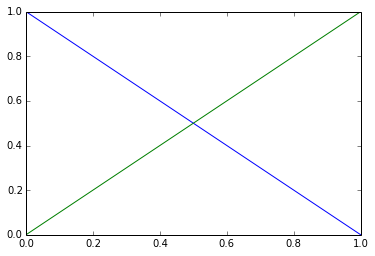

In [12]:
C = construct_cij(Nk,Pk)

V = construct_canonical_basis(C)

s = np.linspace(0,1,1025)
for v in V:
    plt.plot(s, v(s))
plt.show()

In [13]:
from numpy.polynomial.legendre import leggauss

def apply_matrx_bc(A):
    ck = A[0,0]
    A[0] = 0
    A[0,0] = ck
    
    ck = A[-1,-1]
    A[-1] = 0
    A[-1,-1] = ck
    
def apply_rhs_bc(rhs):
    rhs[0] = 0
    rhs[-1] = 0

def assemble_system(x,V,myf):
    
    h = 1./(len(x)-1)

    degree = 2*len(V)-1
    q,w = leggauss(degree) # Gauss between -1 and 1
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    Vpq = np.zeros((len(V), len(q)))

    for i in range(len(V)):
        Vq[i] = V[i](q)
        Vpq[i] = V[i].deriv()(q)

    n_dofs = (len(x)-1)*(len(V)-1)+1

    A = np.zeros((n_dofs, n_dofs))
    M = np.zeros((n_dofs, n_dofs))
    rhs = np.zeros((n_dofs,))

    # Construct the local matrix only once:
    local_A = np.einsum('jq, iq, q -> ij', Vpq/h, Vpq/h, w*h)
    local_M = np.einsum('jq, iq, q -> ij', Vq, Vq, w*h)

    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        A[np.ix_(index, index)] += local_A
        M[np.ix_(index, index)] += local_M

        # The transformation of the quadrature points
        xq = x[i]+h*q
        local_rhs = np.einsum('iq, q, q -> i', Vq, w*h, myf(xq))

        rhs[index] += local_rhs

    # Fix the boundary conditions
    apply_matrx_bc(A)
    apply_matrx_bc(M)
    apply_rhs_bc(rhs)
    #ck = A[0,0]
    #A[0] = 0
    #A[0,0] = ck
    #rhs[0] = 0

    
    #ck = A[-1,-1]
    #A[-1] = 0
    #A[-1,-1] = ck
    #rhs[-1] = 0        

    return A,M,rhs

In [21]:
def evaluate_l2_error(x,V,u,exact_sol):
    h = 1./(len(x)-1)

    degree = 4*(2*len(V)-1)
    q,w = leggauss(degree) # Gauss between -1 and 1
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    
    for i in range(len(V)):
        Vq[i] = V[i](q)
        
        
    error = 0.
    
    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        xq = x[i]+h*q

        fem_sol_k = np.einsum('i,iq -> q', u[index],Vq)
        exact_sol_k = exact_sol(xq)
        
        sq_error = (np.abs(exact_sol_k-fem_sol_k))**2. 
        
        error += np.sum(sq_error*w)#np.einsum('i,i', sq_error,w)

    return np.sqrt(error)

def evaluate_h1_error(x,V,u,exact_sol_der):
    h = 1./(len(x)-1)

    degree = 4*(2*len(V)-1)
    q,w = leggauss(degree) # Gauss between -1 and 1
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    Vpq = np.zeros((len(V), len(q)))
    
    for i in range(len(V)):
        Vq[i] = V[i](q)
        Vpq[i] = V[i].deriv()(q)
        
    error = 0.
    
    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        xq = x[i]+h*q

        fem_sol_k = np.einsum('i,iq -> q', u[index],Vpq/h)
        exact_sol_k = exact_sol_der(xq)
        
        sq_error = (np.abs(exact_sol_k-fem_sol_k))**2. 
        
        error += np.sum(sq_error*w)#np.einsum('i,i', sq_error,w)

    return np.sqrt(error)

In [22]:
import sympy as sym
t = sym.var('t')
sol = sym.sin(sym.pi*t)#(t-1)*t**2#sym.sin(2*sym.pi*t)
sol_der = sym.diff(sol,t,1)
force = -1*sym.diff(sol,t,2)

In [23]:
dx = []
l2_err = []
h1_err = []

exact_sol = sym.lambdify(t, sol, 'numpy')#lambda x: np.sin(2*np.pi*x)
exact_sol_der = sym.lambdify(t, sol_der, 'numpy')
myf = sym.lambdify(t, force, 'numpy')#lambda x: 4*np.pi**2*np.sin(2*np.pi*x)

for n in range(2,20):
    
    n=n**2+1

    x=np.linspace(0,1,n)

    A2, M, rhs = assemble_system(x,V,myf)

    # Solve the system
    sys_m = A2
    ufem = np.linalg.solve(sys_m, rhs)
    
    l2_err.append(evaluate_l2_error(x,V,ufem,exact_sol))
    h1_err.append(evaluate_h1_error(x,V,ufem,exact_sol_der))
    
    dx.append(1./(len(x)-1)) 

#print l2_err
#print dx
print np.diff(np.log(l2_err))/np.diff(np.log(dx))
print h1_err
print np.diff(np.log(h1_err))/np.diff(np.log(dx))

[ 1.48666736  1.49683989  1.49888679  1.49951063  1.49975188  1.49986098
  1.49991612  1.49994642  1.49996418  1.49997515  1.49998223  1.49998693
  1.49999021  1.49999252  1.49999412  1.49999544  1.49999626]
[0.99701694976790611, 0.67017934751029662, 0.50333263389809024, 0.40281888279112871, 0.33572814610635443, 0.28778379212455169, 0.25181795720558053, 0.2238415614922227, 0.20145914232154247, 0.1831456297949321, 0.16788404839321541, 0.15497022763205862, 0.14390113826808681, 0.13430786774253262, 0.12591371909433249, 0.11850709378706339, 0.11192341140623892, 0.1060327378556721]
[ 0.4898355   0.49758768  0.49915001  0.49962631  0.49981053  0.49989384
  0.49993595  0.49995908  0.49997265  0.49998102  0.49998642  0.49999003
  0.49999252  0.49999427  0.49999554  0.49999648  0.49999718]


In [24]:
1.63733964

1.63733964

In [19]:
def interpolation_matrix(s, x, V):
    """
    Given the evaluation points s in the mesh x, construct the interpolation matrix 
    according to the local basis V.
    """
    n_dofs = (len(x)-1)*(len(V)-1)+1

    M = np.zeros((n_dofs, len(s)))
    for i in range(len(x)-1):
        index = s>=x[i]
        index *= s<=x[i+1]
        
        # Transform the points to [0,1]
        xi = (s[index]-x[i])/(x[i+1]-x[i])
        
        for j in range(len(V)):
            k = i*(len(v)-1)+j
            M[k,index] = V[j](xi)
    return M

('Error at the s points:', 1.7601648974911697)
('Error at the x points:', 1.7601367548840239)


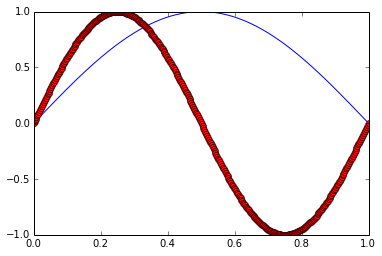

In [20]:
s = np.linspace(0,1,1025)
us = np.sin(2*np.pi*s)
ux = np.sin(2*np.pi*x)

# Use this to plot high resolution versions
M = interpolation_matrix(s,x,V)

# Use this to compute errors at the mesh points
Mx = interpolation_matrix(x,x,V)

plt.plot(s, M.T.dot(ufem))
plt.plot(s, us)
plt.plot(x, ux,'ro')

print("Error at the s points:", (M.T.dot(ufem)-us).max())
print("Error at the x points:", (Mx.T.dot(ufem)-ux).max())